In [2]:
!rm -r /content/the-oxfordiiit-pet-dataset

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
! pip install tensorflow opendatasets --upgrade --quiet

In [9]:
! pip install tensorflow-datasets --upgrade --quiet

In [10]:
import numpy as np
import pandas as pd
import os
import math
import random
import cv2
import tensorflow_datasets as tfds
import opendatasets as od
import xml.etree.ElementTree as et

from glob import glob # python package to read file from foder
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense,Activation, BatchNormalization, Conv2D, MaxPool2D, ReLU, Input, AveragePooling2D,MaxPooling2D,ZeroPadding2D,Flatten,Add,Dropout,GlobalAveragePooling2D
from keras.regularizers import L2
from keras.optimizers import Adam
from PIL import Image

## sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# resnet 50 model
# from tensorflow.keras import layers as L
from keras.models import Model
from tensorflow.keras.applications import resnet50

C:\Users\Tavishi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/devdgohil/the-oxfordiiit-pet-dataset'

In [14]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading the-oxfordiiit-pet-dataset.zip to .\the-oxfordiiit-pet-dataset


100%|██████████| 780M/780M [00:52<00:00, 15.5MB/s] 


In [27]:
ROOT_DIR = "C:\\Users\\Tavishi\\CNN_L_O_PROJECT"

IMAGE_DIR = "C:\\Users\\Tavishi\\CNN_L_O_PROJECT\\the-oxfordiiit-pet-dataset\\images\\images"
ANNOT_DIR = "C:\\Users\\Tavishi\\CNN_L_O_PROJECT\\the-oxfordiiit-pet-dataset\\annotations\\annotations"

In [29]:
df = pd.read_csv('C:\\Users\\Tavishi\\CNN_L_O_PROJECT\\the-oxfordiiit-pet-dataset\\annotations\\annotations\\list.txt', skiprows=6, delimiter=' ', header=None)
df

,0,1,2,3
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25


In [30]:
# length of the jgp files
image_file_name = [i for i in os.listdir(IMAGE_DIR) if os.path.splitext(i)[-1] == '.jpg']
len(image_file_name)

7390

In [31]:
# length of the files other than jgp files
image_file_name_OTHER = [i for i in os.listdir(IMAGE_DIR) if os.path.splitext(i)[-1] != '.jpg']
len(image_file_name_OTHER)

3

In [32]:
num_classes= 37
height= 224
width= 224
global height
global width
global num_classes

In [33]:
def get_data_dict():
    """
    Return data dict structure
    """
    data_dict = {
        "image_name" : list(),
        "image_path" : list(),
        "xmin": list(),
        "ymin": list(),
        "xmax": list(),
        "ymax": list(),
        "width":list(),
        "height": list(),
        "class_label": list(),
        "species_label": list()
        }
    return data_dict

In [34]:
def get_BB(xml_path):
    """
    Parse the XML file and the ground truth Bounding box coordinates
    """
    #parse the annotations
    tree = et.parse(xml_path)  # xml reading library (web scraping )
    root = tree.getroot()

    bbox = root.find("object/bndbox")
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)

    xmin = bbox.find('xmin').text
    xmax = bbox.find('xmax').text

    ymin = bbox.find('ymin').text
    ymax = bbox.find('ymax').text

    return (width,height,(int(xmin),int(ymin)),(int(xmax),int(ymax)))

In [37]:
def validate_file(file): # ('Abyssinian_100')
    """
    Return image path and XML file path if exist
    """
    img_file = file + ".jpg"
    xml_file = file + ".xml"

    img_path = os.path.join(IMAGE_DIR,img_file) #/content/data/oxford-iiit-pet/images/Abyssinian_1.jpg

    xml_path = os.path.join(ANNOT_DIR,"xmls",xml_file)

    if os.path.isfile(img_path):
        if os.path.isfile(xml_path):
            return (img_path,xml_path)
        else:
            print(f"XML file for {img_file} is not available")
            return (img_path,None)

    print(f"Image file for {img_file} is not available")
    return (None,None)

In [38]:
def add_data(img_path,xml_path,data_dict):
    """
    Add the data to the data_dict by parsing the img_path and xml_path
    """
    image = os.path.basename(img_path) # Abyssinian_1.jpg
    data_dict["image_name"].append(image)
    data_dict["image_path"].append(img_path)

    width,height,(xmin,ymin),(xmax,ymax) = get_BB(xml_path)
    data_dict["xmin"].append(xmin)
    data_dict["ymin"].append(ymin)
    data_dict["xmax"].append(xmax)
    data_dict["ymax"].append(ymax)
    data_dict["width"].append(width)
    data_dict["height"].append(height)


    class_name = "_".join(image.split("_")[:-1])
    species_label = "Cat" if class_name[0].isupper() else "Dog"

    data_dict["class_label"].append(class_name.lower())
    data_dict["species_label"].append(species_label)

In [40]:
def get_data(image_path=IMAGE_DIR,
             annot_path=ANNOT_DIR,
             val_split = 0.2):
    """
    Read, Parse and return the train and validation
    """

    with open(os.path.join(annot_path, "trainval.txt"),"r") as train_val_txt:
        ## read the train val file
        train_val_images = train_val_txt.readlines()

        data_dict = get_data_dict()

        for image in train_val_images:

            image = image.strip().split()  # space is default one
            img_path,xml_path = validate_file(image[0])

            if img_path and xml_path:
                add_data(img_path,xml_path,data_dict)

        # Prepare train and validation set
        data_df = pd.DataFrame(data_dict).sort_values(by="class_label")

        # Encode the class label
        encoder = LabelEncoder().fit(data_df["class_label"])

        data_df["class_idx"] = encoder.transform(data_df["class_label"])

    return data_df

In [41]:
data_df= get_data()

XML file for Abyssinian_104.jpg is not available
XML file for Bengal_111.jpg is not available
XML file for samoyed_10.jpg is not available
XML file for Bengal_175.jpg is not available
XML file for Egyptian_Mau_14.jpg is not available
XML file for Egyptian_Mau_156.jpg is not available
XML file for Egyptian_Mau_186.jpg is not available
XML file for Ragdoll_199.jpg is not available
XML file for saint_bernard_15.jpg is not available


C:\Users\Tavishi\AppData\Local\Temp\ipykernel_21012\1545694406.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


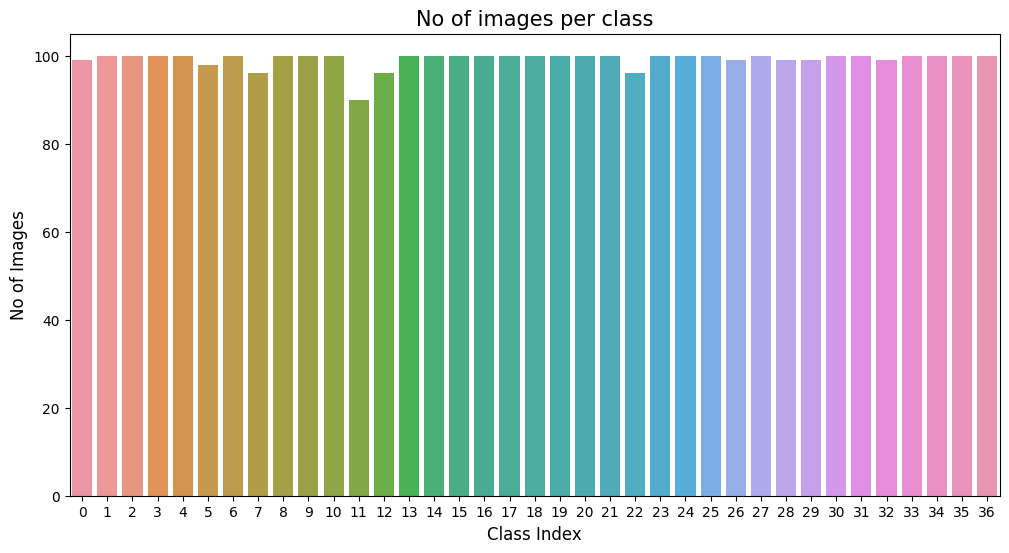

In [42]:
import seaborn as sns
fig, axes = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x=data_df["class_idx"])
axes.set_xlabel("Class Index",fontsize="large")
axes.set_ylabel("No of Images",fontsize="large")
axes.set_title("No of images per class",fontsize=15)
fig.show();

In [43]:
class_to_idx = data_df.groupby(by=["class_idx","class_label","species_label"]).size().to_frame().reset_index()
class_to_idx = class_to_idx.set_index("class_idx").iloc[:,:2]
class_to_idx

,class_label,species_label
class_idx,,
0,abyssinian,Cat
1,american_bulldog,Dog
2,american_pit_bull_terrier,Dog
3,basset_hound,Dog
4,beagle,Dog
5,bengal,Cat
6,birman,Cat
7,bombay,Cat
8,boxer,Dog


In [44]:
class_to_idx.keys()


Index(['class_label', 'species_label'], dtype='object')

In [45]:
def show_image(idx,file,ax):
    img_path,xml_path = validate_file(file)

    if img_path:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if xml_path:
        w,h,pt1, pt2 = get_BB(xml_path)
        img = cv2.rectangle(img, pt1, pt2, (0,255,0), 2)
    if img_path:
        breed = class_to_idx["class_label"][idx]
        species = class_to_idx["species_label"][idx]
        ax.set_title(f"Breed : {breed} | Species : {species}")
        ax.imshow(img)
        ax.set_axis_off()
    else:
        pass

In [46]:
data_df["class_idx"].values

array([ 0,  0,  0, ..., 36, 36, 36])

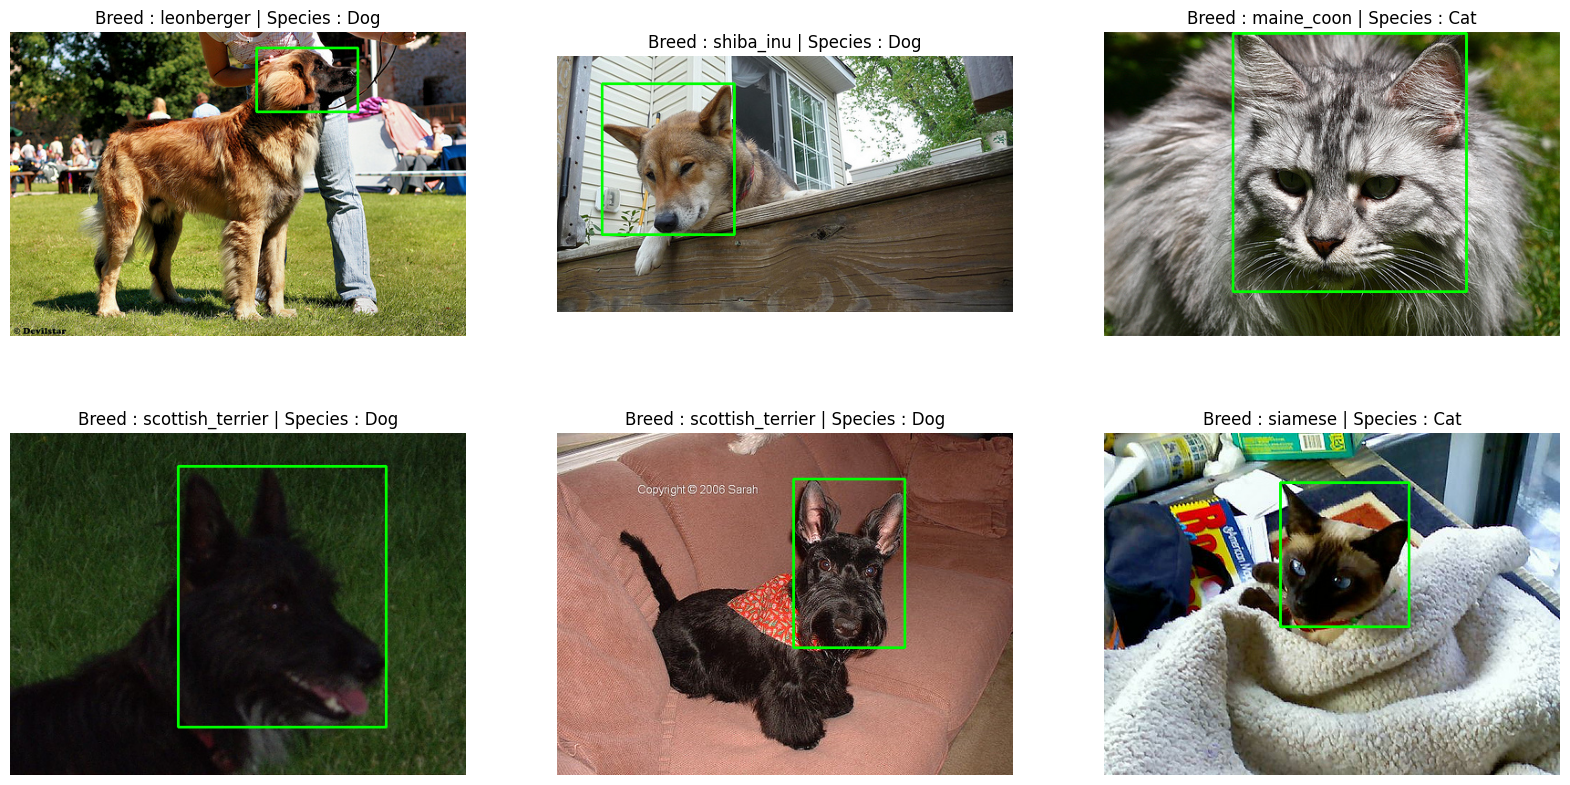

In [47]:
fig,  axes = plt.subplots(2, 3, figsize=(20,10))
axes = [ax for sub_ax in axes for ax in sub_ax]

for idx in range(len(axes)):
  sample = data_df.sample(1)
  class_idx = int(sample["class_idx"].values)
  file = sample["image_name"].to_list()[0].split(".")[0]
  show_image(class_idx,file,axes[idx])
plt.savefig('file1.jpg')


In [48]:
data_df.iloc[:,2:6]

,xmin,ymin,xmax,ymax
0,151,71,335,267
1866,375,53,458,134
1865,42,10,255,205
1864,37,38,183,182
1863,99,34,238,183
...,...,...,...,...
1821,66,17,186,161
1820,52,30,132,107
1819,22,8,206,159
1829,97,4,238,141


In [49]:

def get_input_data(data_df):
  images=[]
  labels=[]
  bboxes=[]

  for idx in data_df.index.values:
    img_details = data_df.loc[idx]

    image_path = img_details['image_path']
    # image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    # image= tf.image.resize(image, (224, 224))
    img = keras.preprocessing.image.load_img(image_path)
    img_arr = keras.preprocessing.image.img_to_array(img)
    image = tf.image.resize(img_arr, (224, 224))
    images.append(image)

    xmin = round(img_details['xmin']/ img_details['width'], 2)
    ymin = round(img_details['ymin']/ img_details['height'], 2)
    xmax = round(img_details["xmax"]/ img_details["width"], 2)
    ymax = round(img_details["ymax"]/ img_details["height"], 2)
    bbox=([xmin,ymin,xmax,ymax])


    bboxes.append(bbox)


    class_label= img_details['class_idx']
    label= [0]*num_classes    # we are making 37 zeros
    label[class_label]= 1  # now replacing the index value with 1
    labels.append(label)
  # print(labels)

  images= np.array(images)/255.
  images = tf.cast(images, dtype=tf.float32)  # cast function is for changing the data type

  labels= np.array(labels)
  labels = tf.cast(labels, dtype=tf.int32)

  bboxes= np.array(bboxes)
  bboxes = tf.cast(bboxes, dtype=tf.float32)

  return images,bboxes,labels


In [ ]:
# train_images, train_boxes,train_labels= get_input_data(train_df)
# val_images, val_boxes, val_labels= get_input_data(val_df)
# test_images, test_boxes, test_labels = get_input_data(test_df)

In [50]:
images,bboxes,labels=get_input_data(data_df)

In [51]:
labels

<tf.Tensor: shape=(3671, 37), dtype=int32, numpy=
array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])>

In [52]:
def parse(image, bbox, label):
    return (image), (bbox, label)

In [53]:
def tf_dataset(images, bboxes, labels, batch=8):
    ds = tf.data.Dataset.from_tensor_slices((images, bboxes, labels))
    ds = ds.map(parse).batch(batch).prefetch(10)
    return ds

In [54]:
tf_dataset(images, bboxes, labels, batch=8)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 37), dtype=tf.int32, name=None)))>

In [55]:
# Train test split
train_df, val_df = train_test_split(data_df,
                                            test_size = 0.2,
                                            stratify=data_df['class_label'])
val_df, test_df= train_test_split(val_df,
                                            test_size = 0.5,
                                            stratify=val_df['class_label'])

In [56]:
train_images, train_boxes,train_labels= get_input_data(train_df)
val_images, val_boxes, val_labels= get_input_data(val_df)
test_images, test_boxes, test_labels = get_input_data(test_df)

In [57]:
# loader
batch_size = 32
lr = 1e-4
num_epochs = 500
train_ds = tf_dataset(train_images, train_boxes, train_labels, batch=batch_size)
valid_ds = tf_dataset(val_images, val_boxes, val_labels, batch=batch_size)
test_df= tf_dataset(test_images, test_boxes, test_labels, batch=batch_size )

In [58]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 37), dtype=tf.int32, name=None)))>

In [59]:
one_instance = train_ds.take(1)

# Iterate over the dataset and print the first instance
for instance in one_instance:
    print(instance)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[6.44450903e-01, 6.71901882e-01, 6.95431292e-01],
         [6.51700079e-01, 6.79151058e-01, 7.02680469e-01],
         [6.65788174e-01, 6.93239152e-01, 7.16768563e-01],
         ...,
         [1.47413164e-01, 1.39710054e-01, 1.43211558e-01],
         [1.82070628e-01, 1.78149059e-01, 1.70305923e-01],
         [2.04130888e-01, 2.00209320e-01, 1.88305780e-01]],

        [[6.41404033e-01, 6.68855011e-01, 6.92384422e-01],
         [6.44602239e-01, 6.72053218e-01, 6.95582628e-01],
         [6.62263036e-01, 6.89714015e-01, 7.13243425e-01],
         ...,
         [1.28312111e-01, 1.20547108e-01, 1.24234274e-01],
         [1.95669189e-01, 1.91438079e-01, 1.84523538e-01],
         [2.01048389e-01, 1.97126821e-01, 1.89283684e-01]],

        [[6.38080835e-01, 6.65531814e-01, 6.89061224e-01],
         [6.38243437e-01, 6.65694416e-01, 6.89223826e-01],
         [6.62184894e-01, 6.89635873e-01, 7.13165283e-01],
         ...,
         

# Main STEP 2

In [60]:
# Nother way of doing the above code

# dataset is smothing we pass to the model , tensrflow requires the data to be in their onw dataset ,
# train_batch_size = 64
# val_batch_size = 32


# train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_boxes, np.argmax(train_labels, axis = 1) ))
# val_dataset= tf.data.Dataset.from_tensor_slices((val_images,val_boxes, np.argmax(val_labels, axis=1)))
# # test_dataset= tf.data.Dataset.from_tensor_slices((test_images,test_boxes,np.argmax( test_labels, axis = 1)))


# train_loader = train_dataset.batch(train_batch_size, drop_remainder=True).shuffle(1024)
# val_loader = val_dataset.batch(val_batch_size, drop_remainder=True)
# # test_loader = test_dataset.batch(val_batch_size, drop_remainder=True)


In [61]:
def res_identity(x, filters):   # here x= 56,56,256
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block
  f1, f2 = filters

  #first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=L2(0.001))(x)  # 56,56,64
  x = BatchNormalization()(x)   # 56,56,64
  x = Activation('relu')(x)    # 56,56,64

  #second block # bottleneck (but size kept same with padding)
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=L2(0.001))(x)
  x = BatchNormalization()(x)         # 56,56,64
  x = Activation('relu')(x)  # 56,56,64

  # third block activation used after adding the input
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=L2(0.001))(x)   # 56,56,256
  x = BatchNormalization()(x)     # 56,56,256
  # x = Activation(activations.relu)(x)      # 56,56,256

  # add the input
  x = Add()([x, x_skip])
  x = Activation('relu')(x)    # 56,56,256

  return x      # 56,56,256

In [62]:
def res_conv(x, s, filters): # x = res_conv(x, s=1, filters=(64, 256))
  '''
  here the input size changes'''
  x_skip = x  # (32, 56, 56, 64)
  f1, f2 = filters

  # first block
  x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=L2(0.001))(x)    # 56,56,64
  # when s = 2 then it is like downsizing the feature map
  x = BatchNormalization()(x)   # 56,56,64
  x = Activation('relu')(x)      ##------->> 56,56,64        if valid formula is n-f+1          hence 56-1+1= 56

  # second block
  x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=L2(0.001))(x)   #
  x = BatchNormalization()(x)   #56,56,64
  x = Activation('relu')(x)     ## 56,56,64                 if same formula will be n+2p-f/stride+1    and here p = f-1/2-----> 3-1/2=1 hence (56+2-3)//1-1= 56

  #third block
  x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=L2(0.001))(x)
  x = BatchNormalization()(x)     ##     32,56,56,256                    # 56-1+1= 56

  # shortcut
  x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=L2(0.001))(x_skip)  # 56, 56, 256
  x_skip = BatchNormalization()(x_skip)  # 56, 56, 256

  # add
  x = Add()([x, x_skip])
  x = Activation('relu')(x)

  return x  # 32,56,56,256

In [63]:
def resnet50():

  input_im = Input(shape=(224,224,3)) # cifar 10 images size
  x = ZeroPadding2D(padding=(3, 3))(input_im)

  # 1st stage
  # here we perform maxpooling, see the figure above

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x) # x shape= 32,224,224,3-------> (224+6-7)//2+1-----111++1  (32,112,112,64)
  x = BatchNormalization()(x) # it will not change the shape
  x = Activation('relu')(x)  # will not change the shape
  x = MaxPooling2D((3, 3), strides=(2, 2))(x) # will change the shape for sure ((size-kernal/stride)+1  (32, 56,56,64)

  #2nd stage
  # frm here on only conv block and identity block, no pooling

  x = res_conv(x, s=1, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  x = res_identity(x, filters=(64, 256))
  print("stage 2nd done")


  # 3rd stage

  x = res_conv(x, s=2, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  x = res_identity(x, filters=(128, 512))
  print("stage 3rd done")

  # 4th stage

  x = res_conv(x, s=2, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  x = res_identity(x, filters=(256, 1024))
  print("stage 4th done")

  # 5th stage

  x = res_conv(x, s=2, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))
  x = res_identity(x, filters=(512, 2048))            # till here trhe output is matrix of shape [32,7,7,2048]  matrix has n dimentions , array has only i dimention , we need to reduce the dimentionality

  # ends with average pooling and dense connection


  # x = Flatten()(x)
  x= GlobalAveragePooling2D()(x)
  x = Dropout(0.5)(x)
  bbox = Dense(4, activation="sigmoid", name="bbox")(x)
  label = Dense(num_classes, activation="softmax", name="label")(x)
  # label = tf.math.argmax(
  #   label,
  #   axis=1,
  #   output_type=tf.dtypes.int64,
  #   name=None
  # )
  print("bbox",bbox.shape)
  print(label.shape)

  # define the model

  model = Model(inputs=input_im, outputs=[bbox,label], name='Resnet50')

  return model

In [64]:
model= resnet50()
model

stage 2nd done
stage 3rd done
stage 4th done
bbox (None, 4)
(None, 37)


In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [66]:
# Here for each head we will define a different loss, we will define it 
# Like a dictionary.

# For classification we will have cateogirical crossentropy
# For the bouding boxes we will have mbinary_crossentropy
losses = { 
    "bbox": "binary_crossentropy",
    "label": "categorical_crossentropy",
    }

# Here you can give more or less weightage to each loss. 

# If you think that detection is harder then the classification then you can 
# Try assinging it more weight
loss_weights = {
    "bbox": 1.0, 
    "label": 1.0
    }

# Set the Metrics
# For the class labels we want to know the Accuracy
metrics = {
    'label': 'accuracy', 
    'bbox':  'accuracy',
    'bbox': 'mse'

    }

# We will be using early stopping to stop the model if total val loss does not
callbacks= [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss',min_delta = 0.0001, patience=20, restore_best_weights=False),
        ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
    ]

# Initialize Optimizer
opt = Adam(learning_rate = 1e-4)

# Compile the model with Adam optimizer
model.compile(optimizer = opt,
               loss = losses,
                loss_weights = loss_weights, 
                metrics = metrics)

In [67]:
# # convert our code into binary language
# lr = 1e-4
# model.compile(
#         # loss="binary_crossentropy",
#         loss = {
#             "bbox": "binary_crossentropy",
#             "label": "categorical_crossentropy",

#         },
#         optimizer=Adam(lr)
#     )

In [ ]:
from tensorflow.keras.applications import resnet50

In [ ]:
# # Train the Model
# history = model.fit(x = train_images, 
#                     y= {
#                         "box_output": train_boxes, 
#                         "class_output": train_labels
#                         }, 
#                     validation_data=(
#                         val_images, 
#                         {
#                           "box_output": val_boxes, 
#                           "class_output": val_labels
#                           }), batch_size = 32, epochs = 500, 
#                     callbacks=[reduce_lr, stop])

In [68]:
num_epochs=200
history = model.fit(
      train_ds,
      epochs=num_epochs,
      validation_data=valid_ds,
      callbacks=callbacks
    )

Epoch 1/200
92/92 [==============================] - ETA: 0s - loss: 23.3817 - bbox_loss: 0.7486 - label_loss: 4.6256 - bbox_mse: 0.0656 - label_accuracy: 0.0296 
Epoch 1: val_loss improved from inf to 22.25646, saving model to model.hdf5
92/92 [==============================] - 2353s 26s/step - loss: 23.3817 - bbox_loss: 0.7486 - label_loss: 4.6256 - bbox_mse: 0.0656 - label_accuracy: 0.0296 - val_loss: 22.2565 - val_bbox_loss: 0.5846 - val_label_loss: 3.7492 - val_bbox_mse: 0.0265 - val_label_accuracy: 0.0272 - lr: 1.0000e-04
Epoch 2/200
92/92 [==============================] - ETA: 0s - loss: 22.6372 - bbox_loss: 0.6773 - label_loss: 4.1417 - bbox_mse: 0.0460 - label_accuracy: 0.0392
Epoch 2: val_loss did not improve from 22.25646
92/92 [==============================] - 598s 6s/step - loss: 22.6372 - bbox_loss: 0.6773 - label_loss: 4.1417 - bbox_mse: 0.0460 - label_accuracy: 0.0392 - val_loss: 22.8103 - val_bbox_loss: 0.5819 - val_label_loss: 4.5262 - val_bbox_mse: 0.0262 - val_lab

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 6)) Aa
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def cal_iou(y_true, y_pred):
    x1 = max(y_true[0], y_pred[0])
    y1 = max(y_true[1], y_pred[1])
    x2 = min(y_true[2], y_pred[2])
    y2 = min(y_true[3], y_pred[3])

    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    true_area = (y_true[2] - y_true[0] + 1) * (y_true[3] - y_true[1] + 1)
    bbox_area = (y_pred[2] - y_pred[0] + 1) * (y_pred[3] - y_pred[1] + 1)

    iou = intersection_area / float(true_area + bbox_area - intersection_area)
    return iou

In [ ]:
test_images, test_boxes, test_labels

In [ ]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
create_dir("result")


In [ ]:
from tqdm.notebook import tqdm
mean_iou = []
pred_labels = []
for image, true_bbox, true_labels in tqdm(zip(test_images, test_boxes, test_labels), total=len(test_images)):
  x= image
  x = np.expand_dims(x, axis=0)  # this is to add the batch size as tensorflow model take (batchsize, height, width, color_hannel)

  true_x1, true_y1, true_x2, true_y2 = true_bbox
  pred_bbox, label = model.predict(x, verbose=0)

  pred_bbox = pred_bbox[0]
  label_index = np.argmax(label[0])
  pred_labels.append(label_index+1)

  """ Rescale the bbox points. """
  pred_x1 = int(pred_bbox[0] * image.shape[1])
  pred_y1 = int(pred_bbox[1] * image.shape[0])
  pred_x2 = int(pred_bbox[2] * image.shape[1])
  pred_y2 = int(pred_bbox[3] * image.shape[0])

  iou = cal_iou(true_bbox, [pred_x1, pred_y1, pred_x2, pred_y2])
  mean_iou.append(iou)

  """ Plot bbox on image """
  image = cv2.rectangle(image, (true_x1, true_y1), (true_x2, true_y2), (255, 0, 0), 2) ## BLUE
  image = cv2.rectangle(image, (pred_x1, pred_y1), (pred_x2, pred_y2), (0, 0, 255), 2) ## RED





  0%|          | 0/368 [00:00<?, ?it/s]

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15


KeyboardInterrupt: ignored

In [ ]:
from tqdm.notebook import tqdm
mean_iou = []
pred_labels = []

for image, true_bbox, true_labels in tqdm(zip(test_images, test_boxes, test_labels), total=len(test_images)):
        """ Extracting the name """
  name = image.split("/")[-1]

  """ Reading the image """
  image = cv2.imread(image, cv2.IMREAD_COLOR)
  x = cv2.resize(image, (width, height))
  x = (x - 127.5) / 127.5
  x = np.expand_dims(x, axis=0)

        """ Bounding box """
  true_x1, true_y1, true_x2, true_y2 = true_bbox

  """ Prediction """
  red_bbox, label = model.predict(x, verbose=0)
  pred_bbox = pred_bbox[0]
  label_index = np.argmax(label[0])
  pred_labels.append(label_index+1)

        """ Rescale the bbox points. """
  pred_x1 = int(pred_bbox[0] * image.shape[1])
  pred_y1 = int(pred_bbox[1] * image.shape[0])
  pred_x2 = int(pred_bbox[2] * image.shape[1])
  pred_y2 = int(pred_bbox[3] * image.shape[0])

        """ Calculate IoU """
  iou = cal_iou(true_bbox, [pred_x1, pred_y1, pred_x2, pred_y2])
  mean_iou.append(iou)

   """ Plot bbox on image """
  image = cv2.rectangle(image, (true_x1, true_y1), (true_x2, true_y2), (255, 0, 0), 2) ## BLUE
  image = cv2.rectangle(image, (pred_x1, pred_y1), (pred_x2, pred_y2), (0, 0, 255), 2) ## RED

        """ Plot predicted class label and score """
  font_size = 1
  pred_class_name = classes[label_index]
  text = f"{pred_class_name}"
  cv2.putText(image, text, (pred_x1, pred_y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, font_size, (0, 0, 255), 2)

        """ Plot true class label """
  font_size = 1
  true_class_name = classes[true_labels-1]
  text = f"{true_class_name}"
  cv2.putText(image, text, (true_x1, true_y1-10), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0), 2)

        """ Plot IoU on image """
  x = 50
  y = 50
  font_size = 1
  cv2.putText(image, f"IoU: {iou:.4f}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 0, 0), 2)
        # print(f"Image Name: {name} - IoU: {iou:.4f} - Pred label: {pred_class_name} - True label: {true_class_name}")

        """ Saving the image """
  cv2.imwrite(f"results/{name}", image)

    """ Mean IoU """
score = np.mean(mean_iou, axis=0)
mean_acc = accuracy_score(test_labels, pred_labels)
print(f"Mean IoU: {score:.4f} - Acc: {mean_acc:.4f}")

In [ ]:
# # from tensorflow.python.module.module import valid_identifier
# num_epochs=1
# result=model.predict(
#       train_loader,
#       # epochs=num_epochs,
#       # validation_data=val_loader,
#         # callbacks=callbacks
#     )

In [ ]:
input_layer= L.Input((224,224,3))

backbone=resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=input_layer,
    input_shape=(224,224,3)
)
backbone.trainable = True

x = backbone.output
x= GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
bbox = Dense(4, activation="sigmoid", name="bbox")(x)
label = Dense(num_classes, activation="softmax", name="label")(x)
print("bbox",bbox.shape)
print(label.shape)

# define the model

model = Model(inputs=[input_layer] , outputs=[label,bbox], name='Resnet50')

model